# Correlation Between Companies in The Same Industry

1. <a href='#Introduction'>Introduction</a>
2. <a href='#Questions'>Questions</a> 
3. <a href='#Data_Sources'>Data Sources</a> 
4. <a href='#Libraries'>Import Required Libraries </a>
5. <a href='#Inputs'>Set Inputs </a>
6. <a href='#Names'>Load and Format S&P500 and ASX Names</a>
9. <a href='#Prices'>Load, Review and Format Prices for FX Rates and Shares</a>
10. <a href='#Pairs'>Create a Universe of Pairs</a>
11. <a href='#Sectors'>Analysis of Names by Sector</a>
13. <a href='#Correlations'>Correlation Results</a>
14. <a href='#References'>References</a>

<a id="introduction"></a>
# Introduction

Pairs Trading is a strategy I believe quantitative tools are well suited for.  "A pairs trade is a trading strategy that involves matching a long position with a short position in two stocks with a high correlation." (Investopida.com 2023). In simple terms, you find two stocks whose prices show high level of correlation.  When they deviate from this correlation, you buy one stock and sell the other and wait for the prior level of correlation to revert to its mean.  If it does so, you will make a profit and vice versa.  Key to this strategy is identifying stocks whose prices  have a high level of correlation to each other - and which are likely to continue to have a high degree of correlation in the future.

Modern computing power lets us identify which pairs have historically shown a high level of correlation through brute force (which is one reason this strategy is one quantiative tools are well suited for - imagine trying to manually analyse tens of thousands of individual pairs.  We can generate correlation statistics for every single combination of pairs possible and then select those which appear stronger than average.  However, the weakness of this approach is that some pairs will show high levels of correlation historically through randomness rather than fundamentals - and their correlation is thus less likely to persist into the future.  

We thus need to identify factors which identify when a high correlation is likely to be due to fundamentals if we want to increase the chance of that correlation persisting.  This assignment will assess whether stocks being members of the same sector are such a factor.  That is, if two companies are in the same sector (industry) are their prices more likely to be correlated  than the prices of two random companies (likely to be in different industries).

This assignment is not a comprehensive test of using a stock's sector or industry as a selection factor for a pairs trading strategy - ***it is only a first step***.  It is identifying if sector appears to be a factor worth assessing further.  Further assessement would include steps such as:
* Analysing the pairs over multiple time periods;
* Increasing the same size;
* Testing not only if historical correlation of pairs in the same industry is stronger than a random benchmark, but also if that persists on a forward basis.



Our approach for this first step is to first analyse if using sector as a factor is practical in the first place:
* how many different sectors are there, 
* what is the distribution across sectors, 
* do we have have enough pairs within our data to perform a meaningful test

It is then to analyse the correlation of the pairs generated.

<a id="Questions"></a>
# Questions

1. Given a sample of 115 diferent stocks:
    * How many different pairs are possible to analyze
    * How many different pairs within the same industry are possible to analyze and compare to the 'total' universe of stocks

2. What is the break down by industry of the sample set of companies taken from the S&P500.

3. What is the overall correlation profile of the pairs within the sample?  

4. Are pairs in the same industry more closely correlated in their price movements than random pairs?

5. Do pairs in some industries show better correlation than others?

6. If there is a difference in correlation across industries, are there any apparent reasons for this or additional steps that could be taken to try and determine those?

# Data Sources

This project uses the following data sets the information contained within are publicly available:

1. sp500_info.csv: 
    * S&P 500 component stocks including their symbol and sector name, and sub sector name <br>
    (Wikipedia 2023)  
    
2. asx_15_info.csv: 
    * Top 20 Shares by Value for the ASX <br>
    (ASX 2023)  
      
3. prices_shares.csv: <br>
    * 12 Months Historical Data for 100 S&P500 shares and 15 ASX shares (in their local currency): <br>
    (Aroussi, 2023; Yahoo Finance, 2023)  
        
4. prices_fx.csv: 
    * 12 Months Historical Data for a basket of currencies: <br>
    (Aroussi, 2023; Yahoo Finance, 2023)
    

# Import Required Libraries

In [1]:
import yfinance as yf
import numpy as np
import pandas as pd

from datetime import datetime, timedelta

import itertools

from random import sample

import matplotlib.pyplot as plt
import seaborn as sns

# Set Inputs

In [2]:
# Target Input Files
STOCK_PRICES_FNAME = "prices_shares.csv"
FX_PRICES_FNAME = "prices_fx.csv"
SP500_MEMBERS_FNAME = "sp500_info.csv"
ASX_MEMBERS_FNAME = "asx_15_info.csv"

In [3]:
# Instead of choosing all 500 names from the S&P500, pick a selection to reduce the file sizes
SP500_SAMPLE_SIZE = 100

In [4]:
# From our list of all generated pairs, select a random sample to reduce processing requiremens
RDM_SAMPLE_SIZE = 4000

# Obtain Names in SP500

In [5]:
#Read the csv file that contains the S&P component information.
sp500_info_df = pd.read_csv(SP500_MEMBERS_FNAME)
sp500_info_df

,Symbol,Security,GICS Sector,GICS Sub-Industry,Headquarters Location,Date added,CIK,Founded
0,MMM,3M,Industrials,Industrial Conglomerates,"Saint Paul, Minnesota",1957-03-04,66740,1902
1,AOS,A. O. Smith,Industrials,Building Products,"Milwaukee, Wisconsin",2017-07-26,4343243243432434,1916
2,ABT,Abbott,Health Care,Health Care Equipment,"North Chicago, Illinois",1957-03-04,1800,1888
3,ABBV,AbbVie,Health Care,Pharmaceuticals,"North Chicago, Illinois",2012-12-31,1551152,2013 (1888)
4,ACN,Accenture,Information Technology,IT Consulting & Other Services,"Dublin, Ireland",2011-07-06,1467373,1989
...,...,...,...,...,...,...,...,...
498,YUM,Yum! Brands,Consumer Discretionary,Restaurants,"Louisville, Kentucky",1997-10-06,1041061,1997
499,ZBRA,Zebra Technologies,Information Technology,Electronic Equipment & Instruments,"Lincolnshire, Illinois",2019-12-23,877212,1969
500,ZBH,Zimmer Biomet,Health Care,Health Care Equipment,"Warsaw, Indiana",2001-08-07,1136869,1927
501,ZION,Zions Bancorporation,Financials,Regional Banks,"Salt Lake City, Utah",2001-06-22,109380,1873


In [6]:
# Trim the number of S&P500 members we are going to review given processing constraints
sp500_info_df = sp500_info_df[:SP500_SAMPLE_SIZE].copy()

Review the number of members to check that it equals the input constant SP500_SAMPLE_SIZE and also that there are no duplicate symbols

In [7]:
print(SP500_SAMPLE_SIZE, sp500_info_df['Symbol'].count(),len(sp500_info_df['Symbol'].unique()))

100 100 100


<span style="color:green">&#x2705;</span>

## Data Formatting for S&P500 Names

Check for any periods in the stock names for US listed stocks (which includes all our S&P500 members).  Yahoo Finance, which is where we download the prices from, uses the convention that A shares and B shares utilize dashes in their names instead of periods.

In [8]:
sp500_info_df[sp500_info_df['Symbol'].str.contains(".", regex=False)]

,Symbol,Security,GICS Sector,GICS Sub-Industry,Headquarters Location,Date added,CIK,Founded
65,BRK.B,Berkshire Hathaway,Financials,Multi-Sector Holdings,"Omaha, Nebraska",2010-02-16,1067983,1839
81,BF.B,Brown–Forman,Consumer Staples,Distillers & Vintners,"Louisville, Kentucky",1982-10-31,14693,1870


In [9]:
# We need to replace periods with dashs within the Symbol columns for S&P500 related names as per Yahoo Finance convention
sp500_info_df['Symbol'] = sp500_info_df['Symbol'].str.replace(".", "-", regex=False)

# Check to ensure this was successful
sp500_info_df[sp500_info_df['Symbol'].str.contains(".", regex=False)]

,Symbol,Security,GICS Sector,GICS Sub-Industry,Headquarters Location,Date added,CIK,Founded


<span style="color:green">&#x2705;</span>

# Obtain Names in ASX

In [10]:
asx_info_df = pd.read_csv(ASX_MEMBERS_FNAME)
asx_info_df

,Symbol,Security,GICS Sector
0,BHP.AX,BHP GROUP,Materials
1,FMG.AX,FORTESCUE,Materials
2,MQG.AX,MACQUARIE GROUP,Financials
3,CBA.AX,COMMONWEATH BANK,Financials
4,RIO.AX,RIO TINTO,Materials
5,CSL.AX,CSL,Health Care
6,WDS.AX,WOODSIDE,Energy
7,ANZ.AX,ANZ GROUP,Financials
8,PLS.AX,PILBARAMIN,Materials
9,NAB.AX,NATIONAL AUSTRALIA BANK,Financials


# Merge ASX and S&P500 Names 

In [11]:
all_stocks_info_df = pd.concat([asx_info_df, sp500_info_df[['Symbol', 'Security', 'GICS Sector']]])
all_stocks_info_df                    

,Symbol,Security,GICS Sector
0,BHP.AX,BHP GROUP,Materials
1,FMG.AX,FORTESCUE,Materials
2,MQG.AX,MACQUARIE GROUP,Financials
3,CBA.AX,COMMONWEATH BANK,Financials
4,RIO.AX,RIO TINTO,Materials
...,...,...,...
95,CBOE,Cboe Global Markets,Financials
96,CBRE,CBRE Group,Real Estate
97,CDW,CDW,Information Technology
98,CE,Celanese,Materials


# Load prices for Shares and FX Rates

In [12]:
# Read the Daily Prices for the Stocks and FX Rates from their respective csv files
stock_prices_df = pd.read_csv(STOCK_PRICES_FNAME)
fx_prices_df = pd.read_csv(FX_PRICES_FNAME)

## Review the Raw FX Data

In [13]:
fx_prices_df.describe()

,AUDUSD=X,HKDUSD=X,JPYUSD=X,SGDUSD=X
count,260.000000,260.000000,260.000000,260.000000
mean,0.694923,0.127710,0.007655,0.725565
std,0.031395,0.000395,0.000632,0.013140
min,0.622394,0.127372,0.006659,0.695082
25%,0.674324,0.127400,0.007209,0.716651
50%,0.695210,0.127454,0.007463,0.726607
75%,0.718500,0.128068,0.008127,0.737178
max,0.758570,0.128718,0.008789,0.745379


It quite difficult to analyze the JPY and HKD columns given they are inverted vs how they are conventionally displayed.

Inverting them for reasonableness analysis:

In [14]:
fx_summ = fx_prices_df.describe()
# Invert FX Rate for display purposes for JPY and HKD to what is conventionally displayed
fx_summ.loc[['mean', 'min', 'max'],['JPYUSD=X', 'HKDUSD=X']] \
            = 1 / fx_summ.loc[['mean', 'min', 'max'],['JPYUSD=X', 'HKDUSD=X']]
fx_summ


,AUDUSD=X,HKDUSD=X,JPYUSD=X,SGDUSD=X
count,260.000000,260.000000,260.000000,260.000000
mean,0.694923,7.830247,130.625851,0.725565
std,0.031395,0.000395,0.000632,0.013140
min,0.622394,7.851000,150.175992,0.695082
25%,0.674324,0.127400,0.007209,0.716651
50%,0.695210,0.127454,0.007463,0.726607
75%,0.718500,0.128068,0.008127,0.737178
max,0.758570,7.768900,113.785000,0.745379


<p style="background-color:#AFE1AF;">
Min and max ranges as well as distributions seem in line with the known characteristics of the currencies.</p>

<p style="background-color:#F88379;">
We do not have the same number of records for each currency.
To fix this we will resample the data using the ffil() function when cleansing and formatting the data.</p>

&#10060;

## Cleanse/ Format FX Prices

Prior to doing the resampling and for later analysis it is better if we convert dates from being string values a column,  to Datetime values and also set them as the index.

In [15]:
# Format the Date and set as the Index
fx_prices_df['Date'] = pd.to_datetime(fx_prices_df['Date'], format = "%Y-%m-%d")
fx_prices_df = fx_prices_df.set_index('Date', drop=True)

Resample data to fill any missing values

In [16]:
# Forward Fill prices
# Note: This will also give a price for the week-ends, but that will get dropped later when we merge with the share prices df
fx_prices_df = fx_prices_df.resample('D').last().ffill()

Check the column counts to ensure they are now consistent

In [17]:
fx_prices_df.describe().loc['count']

AUDUSD=X    362.0
HKDUSD=X    362.0
JPYUSD=X    362.0
SGDUSD=X    362.0
Name: count, dtype: float64

&#x2705;

Here is how our FX data now looks:

In [18]:
fx_prices_df

,AUDUSD=X,HKDUSD=X,JPYUSD=X,SGDUSD=X
Date,,,,
2022-01-03,0.726818,0.128272,0.008685,0.741730
2022-01-04,0.719800,0.128243,0.008671,0.739033
2022-01-05,0.723880,0.128312,0.008608,0.737621
2022-01-06,0.722080,0.128284,0.008611,0.736534
2022-01-07,0.716260,0.128195,0.008631,0.734786
...,...,...,...,...
2022-12-26,0.671249,0.128147,0.007531,0.739809
2022-12-27,0.674459,0.128121,0.007532,0.742501
2022-12-28,0.672993,0.128199,0.007491,0.742060


&#x2705;

## Review the Stock Price Data

In [19]:
stock_prices_df.head()

,Date,A,AAL,AAP,AAPL,ABBV,ABC,ABT,ACGL,ACN,...,NCM.AX,NST.AX,PLS.AX,RIO.AX,RMD.AX,T,TECH,WBC.AX,WDS.AX,WRB
0,2022-01-03,154.908508,18.750000,224.928452,180.434311,126.534706,130.200043,134.805557,44.549999,397.086761,...,NaN,NaN,NaN,NaN,NaN,17.069723,121.268669,NaN,NaN,52.898167
1,2022-01-04,149.671646,19.020000,225.184921,178.144302,126.291786,128.963074,131.635162,45.130001,394.249115,...,23.705288,9.090141,3.428028,92.659813,35.888363,17.210688,116.353668,19.889442,19.334044,53.685848
2,2022-01-05,147.107651,18.680000,224.614975,173.405670,126.955170,130.082260,131.043747,44.599998,387.306091,...,24.005354,9.138391,3.486461,93.394104,34.698036,17.593298,108.077499,20.054728,19.419329,53.086952
3,2022-01-06,147.622437,18.570000,229.554672,170.510956,126.357178,128.069656,131.024323,44.860001,368.602905,...,23.260027,8.723448,3.311164,94.072624,33.368839,17.526175,106.041405,19.724155,18.941734,53.991798
4,2022-01-07,143.692291,19.280001,226.172867,170.679489,126.030144,130.690933,131.431549,45.070000,361.533112,...,23.260027,8.781346,3.408551,96.321960,33.616825,18.124920,103.242081,19.972084,19.359629,55.059402
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
253,2022-12-23,148.481873,12.710000,141.008759,131.477127,158.336105,169.002655,106.645416,63.380001,263.014862,...,20.513069,10.947768,3.700712,112.412163,31.405985,17.485210,82.562065,22.741936,33.806393,72.699135
254,2022-12-27,148.800278,12.530000,142.721176,129.652435,158.229309,167.998657,107.029884,63.619999,262.243866,...,NaN,NaN,NaN,NaN,NaN,17.628454,82.043106,NaN,NaN,73.154449
255,2022-12-28,147.347595,12.320000,142.996735,125.674026,157.491501,166.368362,106.300385,62.599998,260.079224,...,20.562428,11.007159,3.564371,114.720200,30.418627,17.399263,80.526199,22.732258,34.701988,72.055794
256,2022-12-29,150.332550,12.700000,143.990707,129.233658,157.811859,165.066132,108.745201,63.110001,265.278412,...,20.434097,10.957666,3.583848,114.019028,30.398680,17.618904,84.298523,22.519356,33.127625,72.491295


**Lets Review the price values for reasonableness**

In [20]:
print(f"Minimium Share Price Value Across All Stocks: ${stock_prices_df.select_dtypes(include='number').min().min():,.02f}")
print(f"Maximum Share Price Value Across All Stocks: ${stock_prices_df.select_dtypes(include='number').max().max():,.02f}")
print(f"Mean Share Price Value Across All Stocks: ${stock_prices_df.select_dtypes(include='number').mean().mean():,.02f}")

Minimium Share Price Value Across All Stocks: $1.99
Maximum Share Price Value Across All Stocks: $2,703.26
Mean Share Price Value Across All Stocks: $160.65


The range of values for individual shares prices is quite large and thus direct comparision of absolute values would required scaling of the prices.
However, the range seems reasonable given the dataset - there are no negative values and no extremely large or small values.

&#x2705;

Lets create a scatter plot to visualize the price data

Text(0.5, 1.0, 'Mean Price for Each Company')

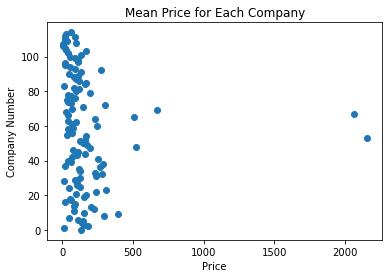

In [21]:
av_prices_by_stock = stock_prices_df.select_dtypes(include='number').mean()
av_prices_by_stock.index = pd.Series(range(len(av_prices_by_stock)))
plt.scatter(x = av_prices_by_stock.values,
            y = av_prices_by_stock.index,
           )
plt.xlabel('Price')
plt.ylabel('Company Number')
plt.title('Mean Price for Each Company')


<p style="background-color:Yellow;"><b>Not Great:</b> That does not look so great with a small number of obvious outliers.</p>

Lets check to see if these represent errors or just outliers.

In [22]:
# Largest two price values by stock
stock_prices_df.select_dtypes(include='number').max().sort_values()[-2:]


AZO     2579.00000
BKNG    2703.26001
dtype: float64

Checking these manually to price sources (Yahoo Finance, 2023), the prices look accurate.  Thus the values represent outliers rather than errors.

While there are several ways to handle these outliers depending the analysis being performed and the reason for the outliers, for our analysis we are going to retain them in our data set.

**Examing the Number of Records for Each Stock**

In [23]:
print(stock_prices_df.describe().loc['count'].describe())

count    115.0
mean     251.0
std        0.0
min      251.0
25%      251.0
50%      251.0
75%      251.0
max      251.0
Name: count, dtype: float64


<p style="background-color:#AFE1AF;">
    The maximum number of rows is 252, and this is the case for >75% of the rows.  As a reasonableness check, there are 260 (52 * 5) week days in the year and some of these will be public holidays.  So we expect somewhere around 250 trading days in a year given stock markets are not open on week-ends and we have to then deduct for public holidays - so 252 looks reasonable. 
</p>

## Format Share Pricing Data

### Convert the dates to datetime format and set them as the index

In [24]:
stock_prices_df['Date'] = pd.to_datetime(stock_prices_df['Date'], format = "%Y-%m-%d")
stock_prices_df = stock_prices_df.set_index('Date', drop=True)

### Convert Share Prices to USD Equivalent

To Convert from local currencies to a USD Equivalent we add a column for the FX rate applicable given the ticker code format:
* Australian stocks have .AX in their ticker, 
* Japanese stocks have .T, 
* Hong Kong stocks .HK, 
* Singapore stocks .SI; and
* US stocks have no period in their ticker

In [25]:
# Add currency column based on ticker code format
for ticker in stock_prices_df.columns:
    if ".AX" in ticker:
        stock_prices_df[ticker] = stock_prices_df[ticker] * fx_prices_df["AUDUSD=X"]
    elif ".HK" in ticker:
        stock_prices_df[ticker] = stock_prices_df[ticker] * fx_prices_df["HKDUSD=X"]
    elif ".T" in ticker:
        stock_prices_df[ticker] = stock_prices_df[ticker] * fx_prices_df["JPYUSD=X"]
    elif ".SI" in ticker:
        stock_prices_df[ticker] = stock_prices_df[ticker] * fx_prices_df["SGDUSD=X"]

### Eliminate shares with less than 245 trading days

In [26]:
# Identify Names Which Should be Eliminated
low_counts = stock_prices_df.count()[stock_prices_df.count()<250]
print(low_counts)

low_counts = list(low_counts.index)
print(low_counts)

Series([], dtype: int64)
[]


In [27]:
# Eliminate Names with a Low Number of Trading Days Present
stock_prices_df = stock_prices_df.drop(columns=low_counts).copy()

In [28]:
# Check removal was successful
stock_prices_df.count().min()

251

&#x2705;

### Fill Prices for Names Missing only a Small Number of Days

In [29]:
# Forward fill any missing stock prices
stock_prices_df.fillna(method='ffill', inplace=True)

# Backward fill any remaining missing stock prices
stock_prices_df.fillna(method='bfill', inplace=True)

stock_prices_df

,A,AAL,AAP,AAPL,ABBV,ABC,ABT,ACGL,ACN,ADBE,...,NCM.AX,NST.AX,PLS.AX,RIO.AX,RMD.AX,T,TECH,WBC.AX,WDS.AX,WRB
Date,,,,,,,,,,,,,,,,,,,,,
2022-01-03,154.908508,18.750000,224.928452,180.434311,126.534706,130.200043,134.805557,44.549999,397.086761,564.369995,...,17.063065,6.543083,2.467495,66.696527,25.832441,17.069723,121.268669,14.316419,13.916643,52.898167
2022-01-04,149.671646,19.020000,225.184921,178.144302,126.291786,128.963074,131.635162,45.130001,394.249115,554.000000,...,17.063065,6.543083,2.467495,66.696527,25.832441,17.210688,116.353668,14.316419,13.916643,53.685848
2022-01-05,147.107651,18.680000,224.614975,173.405670,126.955170,130.082260,131.043747,44.599998,387.306091,514.429993,...,17.377001,6.615100,2.523780,67.606146,25.117222,17.593298,108.077499,14.517221,14.057268,53.086952
2022-01-06,147.622437,18.570000,229.554672,170.510956,126.357178,128.069656,131.024323,44.860001,368.602905,514.119995,...,16.795601,6.299028,2.390925,67.927965,24.094973,17.526175,106.041405,14.242419,13.677448,53.991798
2022-01-07,143.692291,19.280001,226.172867,170.679489,126.030144,130.690933,131.431549,45.070000,361.533112,510.700012,...,16.660227,6.289727,2.441409,68.991569,24.078388,18.124920,103.242081,14.305205,13.866528,55.059402
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-12-23,148.481873,12.710000,141.008759,131.477127,158.336105,169.002655,106.645416,63.380001,263.014862,338.450012,...,13.698630,7.310921,2.471336,75.068857,20.972921,17.485210,82.562065,15.187068,22.575913,72.699135
2022-12-27,148.800278,12.530000,142.721176,129.652435,158.229309,167.998657,107.029884,63.619999,262.243866,335.089996,...,13.698630,7.310921,2.471336,75.068857,20.972921,17.628454,82.043106,15.187068,22.575913,73.154449
2022-12-28,147.347595,12.320000,142.996735,125.674026,157.491501,166.368362,106.300385,62.599998,260.079224,328.329987,...,13.838365,7.407739,2.398796,77.205864,20.471516,17.399263,80.526199,15.298645,23.354187,72.055794


# Create a Universe of Pairs

Now that we have imported and cleansed the data, we need to start manipulating it to get the answers required.

Key to this is breaking the price data for all the companies into pairs that can be analyzed.  For Example, Microsoft (MSFT) vs Google (GOOGL).


Using all the names we have data for, we can create a list of all possible pair combinations using the itertools library.

In [30]:
all_possible_pairs = [list(pair) for pair in itertools.combinations(stock_prices_df.columns, 2)]

print(f"The Number of All Possible Unique Pairs is: {len(all_possible_pairs):,.0f}")
print(f"\nSome Examples: {all_possible_pairs[:5]} \n{all_possible_pairs[-5:]}")


The Number of All Possible Unique Pairs is: 6,555

Some Examples: [['A', 'AAL'], ['A', 'AAP'], ['A', 'AAPL'], ['A', 'ABBV'], ['A', 'ABC']] 
[['TECH', 'WDS.AX'], ['TECH', 'WRB'], ['WBC.AX', 'WDS.AX'], ['WBC.AX', 'WRB'], ['WDS.AX', 'WRB']]


We may want to instead look at a sample of names, instead of the full universe.  This may be because we have processing constrainsts etc.  However, we want a random sample rather than just picking the first 100 names in case their is some bias in the way they are ordered.

We have set the sample size via the input constant (RDM_SAMPLE_SIZE) in the Set Inputs section.

In [31]:
# Select a sample of pairs randomly from the our universe of all possible pairs
random_pairs = sample(all_possible_pairs, RDM_SAMPLE_SIZE)
print(random_pairs[:5])

[['AES', 'BBWI'], ['BBWI', 'MQG.AX'], ['ATO', 'BALL'], ['APH', 'CBOE'], ['AES', 'BRK-B']]


## Add Industry to Pairs List

The key factor we are seeking to test is Industry.  That is, if in names in the same industry show better correlation or related statistics vs random pairs. 

To do this we are going to have to merge information from multiple inputs:
- the ticker names for the pairs will come from the list of pairs we generated;
- the Industry name will come from the all_stocks_info_df
- Same Industry Column will be a engineered column we create

The Same Industry column will make queries and analysis on the dataset simplier.


In [32]:
# Build a DataFrame which lists all possible pairs, the industry of each name in the pair and if they are the same.

# Start with the all the pair combinations
all_possible_pairs_df = pd.DataFrame(all_possible_pairs, columns=['Ticker1', 'Ticker2'])

# write to csv to check file size
all_possible_pairs_df.to_csv("all_possible_pairs_df.csv")

# Add the Industry Name for the first ticker
all_possible_pairs_df = pd.merge(all_possible_pairs_df, all_stocks_info_df[['Symbol', 'GICS Sector']], how='inner', left_on = 'Ticker1', right_on = 'Symbol')
# Add the Industry name for the second ticker
all_possible_pairs_df = pd.merge(all_possible_pairs_df, all_stocks_info_df[['Symbol', 'GICS Sector']], how='inner', left_on = 'Ticker2', right_on = 'Symbol')

# Remove excess columns and tidy up column names
all_possible_pairs_df.drop(columns = ['Symbol_x', 'Symbol_y'], inplace=True)
all_possible_pairs_df.rename(columns={"GICS Sector_x": "Ind1", "GICS Sector_y": "Ind2"}, inplace=True)

# Create a new column 'Same Industry' which identifies if all the two names in the pair are from the same industry
all_possible_pairs_df['Same Industry'] = np.where(all_possible_pairs_df['Ind1'] == all_possible_pairs_df['Ind2'], 'Yes', 'No')
all_possible_pairs_df

,Ticker1,Ticker2,Ind1,Ind2,Same Industry
0,A,AAL,Health Care,Industrials,No
1,A,AAP,Health Care,Consumer Discretionary,No
2,AAL,AAP,Industrials,Consumer Discretionary,No
3,A,AAPL,Health Care,Information Technology,No
4,AAL,AAPL,Industrials,Information Technology,No
...,...,...,...,...,...
6550,RMD.AX,WRB,Health Care,Financials,No
6551,T,WRB,Communication Services,Financials,No
6552,TECH,WRB,Health Care,Financials,No
6553,WBC.AX,WRB,Financials,Financials,Yes


Construct a DataFrame for the Random Pairs sample in the same format as that for all the possible pairs.

In [33]:
#Build the base df from the list of list of random pairs
random_pairs_df = pd.DataFrame(random_pairs, columns=['Ticker1', 'Ticker2'])

# Add the extra columns required via merging with the df containing all the pairs
random_pairs_df = pd.merge(random_pairs_df, all_possible_pairs_df, how='inner',
                          left_on= ['Ticker1', 'Ticker2'],
                          right_on= ['Ticker1', 'Ticker2'])

random_pairs_df


,Ticker1,Ticker2,Ind1,Ind2,Same Industry
0,AES,BBWI,Utilities,Consumer Discretionary,No
1,BBWI,MQG.AX,Consumer Discretionary,Financials,No
2,ATO,BALL,Utilities,Materials,No
3,APH,CBOE,Information Technology,Financials,No
4,AES,BRK-B,Utilities,Financials,No
...,...,...,...,...,...
3995,AMAT,APTV,Information Technology,Consumer Discretionary,No
3996,ADBE,CZR,Information Technology,Consumer Discretionary,No
3997,BALL,BAX,Materials,Health Care,No
3998,BLK,WBC.AX,Financials,Financials,Yes


# Analysis of Names by Sector

In [34]:
all_stocks_info_df['GICS Sector'].describe()

count            115
unique            11
top       Financials
freq              22
Name: GICS Sector, dtype: object

In [35]:
print(f"The Minimum Number of Members within a Sector Group is: {all_stocks_info_df.groupby('GICS Sector').size().min()}")
print(f"The Median Number of Members within a Sector Group is: {all_stocks_info_df.groupby('GICS Sector').size().median()}")


The Minimum Number of Members within a Sector Group is: 3
The Median Number of Members within a Sector Group is: 11.0


In [36]:
all_stocks_info_df.groupby('GICS Sector').size()

GICS Sector
Communication Services     4
Consumer Discretionary    11
Consumer Staples           5
Energy                     3
Financials                22
Health Care               18
Industrials               13
Information Technology    14
Materials                 12
Real Estate                7
Utilities                  6
dtype: int64

### Build and Display Graphs Analysing the Distribution of the Sector Groups

In [37]:
# Get Counts of The Number of Names Within Each Sector
sector_counts = all_stocks_info_df.groupby('GICS Sector')['Symbol'].count().sort_values(axis=0)

# Bucket The Industries into Those That Have a High Number of Members and "Others"
sector_counts_series = sector_counts[-8:]
sector_counts_series['Other'] = sector_counts_series[:-8].sum()

In [38]:
# Create a seaborn color palette for our graphs
colors = sns.color_palette("Blues", len(sector_counts_series))

In [39]:
# Function to Create a Series of Graphs to Show the Distribution and Makeup of the Sector Membership
def display_sector_graphs(colors, sector_counts, sector_counts_series):
    
    fig = plt.figure(figsize=(10, 25))
    fig.suptitle('Sector Category Splits', y = 0.95, fontweight='bold')

    # Display Pie Chart
    ax = fig.add_subplot(3, 1, 1)
    ax.pie(sector_counts_series, labels = sector_counts_series.index,colors = colors)
    ax.set_title('Sector Split', fontweight='bold')

    # Bar Chart of the Sub-Industries With the Most Members
    ax = fig.add_subplot(3, 1, 2)
    ax.barh(sector_counts_series[:-1].index , sector_counts_series[:-1].values)
    ax.set_title('Top Sector Member Numbers', fontweight='bold')

    # Display Box Plot
    ax = fig.add_subplot(3, 1, 3)
    ax.boxplot(all_stocks_info_df.groupby('GICS Sector')['Symbol'].count())
    ax.set_title('Distribution of Number of Members Within Each Sector', fontweight='bold')

    #fig.tight_layout()
    plt.subplots_adjust(hspace = 0.5)
    
    return fig

When we review the how many stocks/ companies fall into each Sector we see that most Sub-Industries only have a very small number of members.  However, there are also a small number of Sub-Industries that have 10 plus members.

So the distribution is definitely quite skewed.

The following graphs demonstrate that distribution and also highlights which Sector groups have the most number of members.

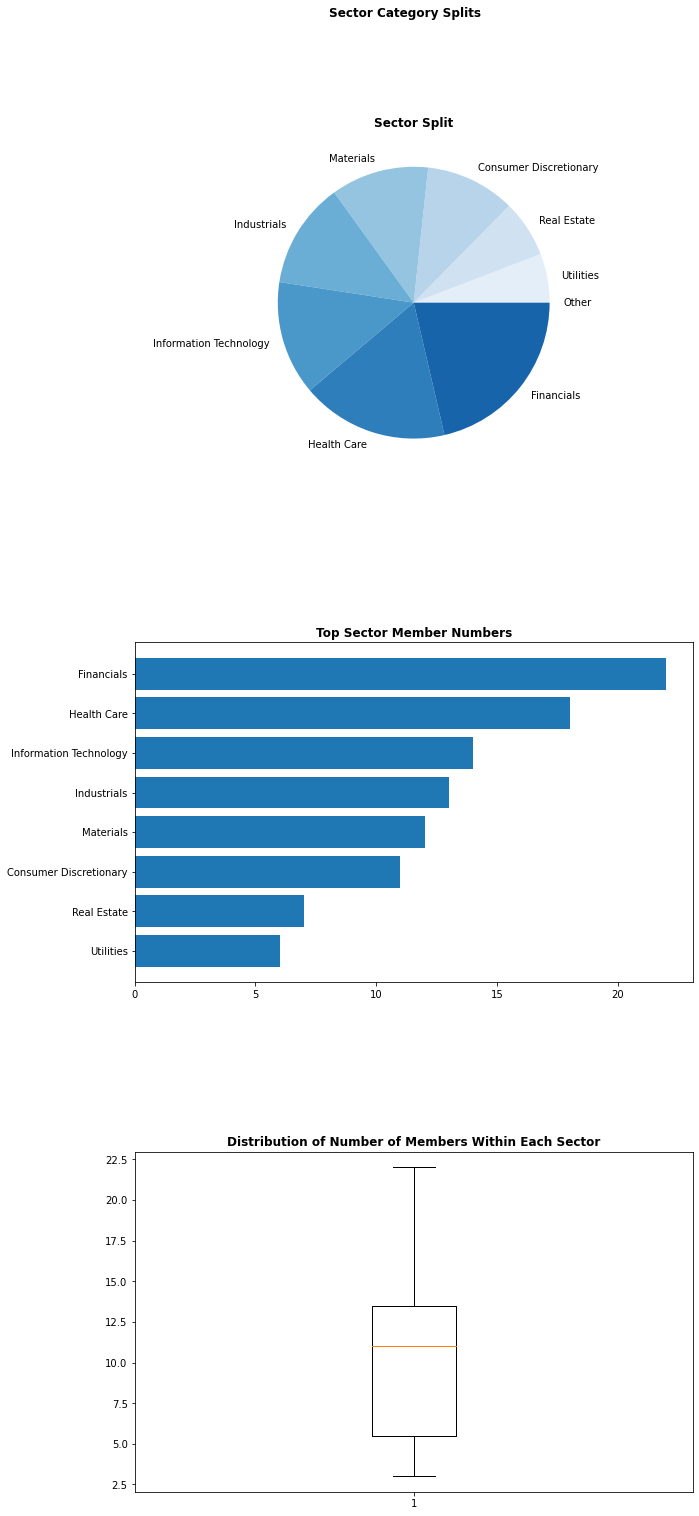

In [40]:
fig = display_sector_graphs(colors, sector_counts, sector_counts_series)
#plt.show()

Where the Sector only has a single member, comparing members within the same industry will not be possible.

Given we are looking to compare companies within the same industry vs companies not in the same industry, we want to identify if any sectors have less than 2 names in them.

In [41]:
all_stocks_info_df.groupby('GICS Sector')['Symbol'].count()

GICS Sector
Communication Services     4
Consumer Discretionary    11
Consumer Staples           5
Energy                     3
Financials                22
Health Care               18
Industrials               13
Information Technology    14
Materials                 12
Real Estate                7
Utilities                  6
Name: Symbol, dtype: int64

## Analyse Ratio of Same Industry Vs Different Industry Pairs

### Full Universe of Names

In [42]:
num_pairs_all = len(all_possible_pairs_df.index)
num_pairs_same_ind_all = len(all_possible_pairs_df[all_possible_pairs_df['Same Industry'] == 'Yes'].index)

print(f"Number of Pairs In Total: {num_pairs_all:,}")
print(f"Number of Pairs in the Same Industry: {num_pairs_same_ind_all:,}")
print(f"Percentage of pairs in the same industry: {num_pairs_same_ind_all/num_pairs_all * 100:,.02f}%")

Number of Pairs In Total: 6,555
Number of Pairs in the Same Industry: 729
Percentage of pairs in the same industry: 11.12%


### Sample

In [43]:
num_pairs_all_samp = len(random_pairs_df.index)
num_pairs_same_ind_samp = len(random_pairs_df[random_pairs_df['Same Industry'] == 'Yes'].index)

print(f"Number of Pairs In Total: {num_pairs_all_samp:,}")
print(f"Number of Pairs in the Same Industry: {num_pairs_same_ind_samp:,}")
print(f"Percentage of pairs in the same industry: {num_pairs_same_ind_samp/num_pairs_all_samp * 100:,.02f}%")

Number of Pairs In Total: 4,000
Number of Pairs in the Same Industry: 435
Percentage of pairs in the same industry: 10.88%


In [44]:
df = pd.DataFrame(data = [[num_pairs_all, num_pairs_same_ind_all, num_pairs_same_ind_all/num_pairs_all * 100], 
                          [num_pairs_all_samp, num_pairs_same_ind_samp, num_pairs_same_ind_samp/num_pairs_all_samp * 100]], 
                  columns=['Number of Total Pairs', 'Number of Pairs in Same Industry', '% of Pairs in the Same Industry'])
df.index = ['Entire Population', 'Sample']
df

,Number of Total Pairs,Number of Pairs in Same Industry,% of Pairs in the Same Industry
Entire Population,6555,729,11.121281
Sample,4000,435,10.875000


<p style="background-color:#AFE1AF;">
Our sample does seem representative of the total population in term pairs in the same industry vs all pairs.
</p>

# Calculate The Correlation Between Various Pairs

In [45]:
corr_array = []
for i in range(len(random_pairs_df)):
    
    #ratio = stock_prices_df[pair[0]]/ stock_prices_df[pair[1]]
    corr = stock_prices_df[random_pairs[i][0]].corr(stock_prices_df[random_pairs[i][1]])
    
    corr_array.append([random_pairs[i][0], random_pairs[i][1], corr])
    
    i += 1
    
corr_df = pd.DataFrame(data=corr_array, columns=['Ticker1', 'Ticker2', 'Correlation'])
corr_df = pd.merge(corr_df, random_pairs_df, how='inner',
                  left_on = ['Ticker1', 'Ticker2'], right_on = ['Ticker1', 'Ticker2'])

corr_df

,Ticker1,Ticker2,Correlation,Ind1,Ind2,Same Industry
0,AES,BBWI,-0.118720,Utilities,Consumer Discretionary,No
1,BBWI,MQG.AX,0.780635,Consumer Discretionary,Financials,No
2,ATO,BALL,-0.052732,Utilities,Materials,No
3,APH,CBOE,0.621108,Information Technology,Financials,No
4,AES,BRK-B,0.027679,Utilities,Financials,No
...,...,...,...,...,...,...
3995,AMAT,APTV,0.923138,Information Technology,Consumer Discretionary,No
3996,ADBE,CZR,0.831939,Information Technology,Consumer Discretionary,No
3997,BALL,BAX,0.948657,Materials,Health Care,No
3998,BLK,WBC.AX,0.327385,Financials,Financials,Yes


## Analyze Correlations

We are analyzing the absolute values of the correlations as we are interested in the magnitude of the corrleations - negative correlations are as usual as positive ones.

In [46]:
# Absolute correlation levels for ALL pairs
corr_all = abs(corr_df['Correlation']).describe() # Convert correlations to absolute values

# Absolute correlation levels for pairs in the same industry
corr_same_ind = abs(corr_df[corr_df['Same Industry'] == 'Yes']['Correlation']).describe()

# Combine the different correlation serieses into a DF for easier display and analysis
df = pd.DataFrame(corr_all)
df = pd.DataFrame({'Corr all': corr_all, 'Corr Same Industry': corr_same_ind})
df.loc['Median', :]= [abs(corr_df['Correlation']).median(), abs(corr_df[corr_df['Same Industry'] == 'Yes']['Correlation']).median()]
df

,Corr all,Corr Same Industry
count,4000.000000,435.000000
mean,0.428412,0.482198
std,0.261308,0.266068
min,0.000010,0.001131
25%,0.204590,0.260485
50%,0.407937,0.482657
75%,0.639191,0.705557
max,0.999787,0.999787
Median,0.407937,0.482657


<p style="background-color:#B8E2F2;">
    <b>Finding:</b> At a summary level there does appear to be a higher correlation level for pairs in the same industry
</p>

## Analyse by Industry : Are Some Industry Groups Better Than Others?

Creating a DataFrame which gives us some summary info by Industry for Pairs Which are Both in the Same Industry

In [47]:
# Take the df of all correlations, extract same industry pairs and get the median correlation and count for those those pairs
df = corr_df[corr_df['Same Industry'] == 'Yes'].groupby('Ind1').agg(Median =('Correlation', 'median'),\
                                                                   Count=('Correlation','count'))
df = df.reset_index()
df['Median'] = abs(df['Median'])
df = df.sort_values(['Median', 'Count']).set_index('Ind1', drop=True)
df.index.name = ""


If we only have one pair in an industry, it is difficult to make any comparision of that industry vs another.  Thus we will limit our comparison to industries with at least 10 names in it.

In [48]:
# Limit our target dataframe to only include sectors with 10 or more members
#df = df.sort_values('Count')
df = df[df['Count']>=10]
df = df.sort_values('Median')
df

,Median,Count
,,
Health Care,0.126069,89
Materials,0.205349,38
Industrials,0.385538,50
Financials,0.387220,140
Utilities,0.618543,11
Information Technology,0.677396,56
Consumer Discretionary,0.711880,27
Real Estate,0.894100,12


## Display Results Graphically

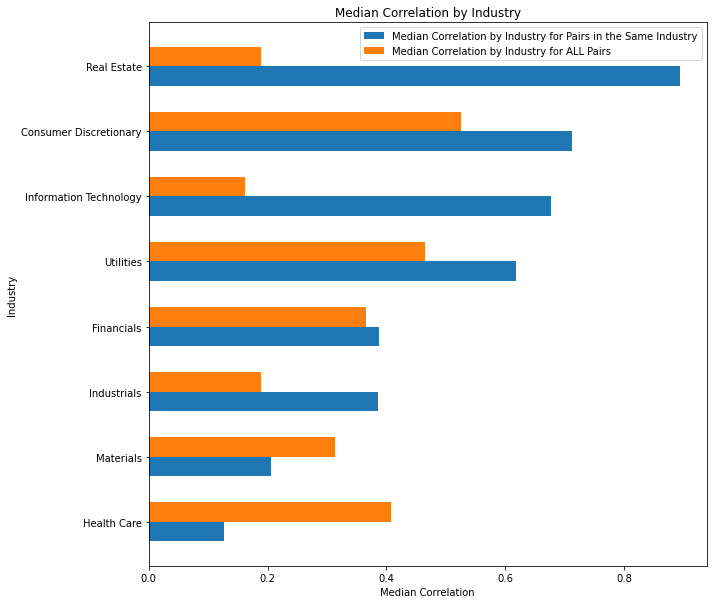

In [49]:
# Calculate median correlations
medians_same_ind = abs(df['Median'])
medians_all_ind = abs(corr_df.groupby('Ind1')['Correlation'].median())

# We only want to plot the industries that have sufficient same industry pairs
medians_all_ind = medians_all_ind[medians_all_ind.index.isin(df.index)]

# Create figure and axis
fig, ax = plt.subplots(figsize=[10,10])

# Set a width for the bars
bar_width = 0.3

# We have to define bar positions if we want the different plots to be side by side
bar1_positions = np.arange(len(medians_same_ind))
bar2_positions = bar1_positions + bar_width # Puts the position beside the prior bar

# Create our bar charts
ax.barh(bar1_positions, medians_same_ind, height=bar_width, label='Median Correlation by Industry for Pairs in the Same Industry')
ax.barh(bar2_positions, medians_all_ind, height=bar_width, label='Median Correlation by Industry for ALL Pairs')

# Define y labels and title
ax.set_yticks(bar1_positions + bar_width / 2)
ax.set_yticklabels(medians_same_ind.index)
ax.set_xlabel('Median Correlation')
ax.set_ylabel('Industry')
ax.set_title('Median Correlation by Industry')

# Show legend
ax.legend()

# Show plot
#plt.show()

<div class="alert alert-block alert-info">
<b>Finding:</b> The range of correlations does vary signficantly across industries
</div>

<div class="alert alert-block alert-info">
<b>Finding:</b> This graph also reinforces the earlier finding that the correlation levels are higher for pairs which are both in the same industry vs disparate pairs - as the same industry pairs have higher correlation for almost all industries</div>

<div class="alert alert-block alert-info">
<b>Finding:</b> It appears that there seems to be INVERSE correlation between the number of members in the Sector and the Median correlation of Sector Members.
    
One possible explanation for this may be that Sectors with larger numbers of members may also be those defined broadly.  If the Sector is quite broad the business models within that sector are likley to become less closely related.

This would require further data analysis and possibly include trying to create sub sectors to see if that creates higher correlation levels.
</div>

In [50]:
df.corr()

,Median,Count
Median,1.000000,-0.549668
Count,-0.549668,1.000000


# References

Aroussi, R., 2023, yfinance.[python library]  
> Available at https://pypi.org/project/yfinance/(Accessed: 3 August, 2023)

ASX, 2023.  *Top 20 Shares by Value.* [pdf] 
> Available at https://www.asx.com.au/data/dw_sharesbyvalue.pdf (Accessed, August 3 2023).

Investopedia.com, 2023. *Pairs Trade: Definition, How Strategy Works, and Example*
https://www.investopedia.com/terms/p/pairstrade.asp (Accessed: 8 August, 2023)

Wikipedia, 2023. *S&P 500 component stocks.*
> Available at https://en.wikipedia.org/wiki/List_of_S%26P_500_companies (Accessed: July 31 2023)

Yahoo Finance, 2023.  *Stock Market and Foreign Currency Historical Market Data.*  
> Available at:
    https://finance.yahoo.com/quote/[Symbol_Code]/history?p=[Symbol_Code](Accessed: 3 August, 2023)

Yahoo Finance, 2023.  *Company Profile Data Incuding Sector Name.*  
> Available at:
    https://finance.yahoo.com/quote/[Symbol_Code]/profile?p=[Symbol_Code](Accessed: 3 August, 2023)

> Note: 115 different stocks and four different foreign currencies were analyzed and thus the individual symbol codes for each are not listed.


In [51]:
# Observe when notebook was last run all the way through successfully
print(datetime.now())

2023-08-08 16:24:20.229951
